In [1]:
%%bash

# Install BARTs dependencies
apt-get install -y make gcc libfftw3-dev liblapacke-dev libpng-dev libopenblas-dev bc &> /dev/null

# Clone Bart
[ -d /content/bart ] && rm -r /content/bart
git clone https://github.com/mrirecon/bart/ bart &> /dev/null


BRANCH=v0.7.00

cd bart

# Switch to desired branch of the BART project
git checkout -q $BRANCH

# Define specifications 
COMPILE_SPECS="PARALLEL=1"

printf "%s\n" $COMPILE_SPECS > Makefiles/Makefile.local

make &> /dev/null



In [2]:
import os
import sys

# Define environment variables for BART and OpenMP

os.environ['TOOLBOX_PATH'] = "/content/bart"

os.environ['OMP_NUM_THREADS']="4"

# Add the BARTs toolbox to the PATH variable

os.environ['PATH'] = os.environ['TOOLBOX_PATH'] + ":" + os.environ['PATH']
sys.path.append(os.environ['TOOLBOX_PATH'] + "/python")

In [3]:
%%bash
echo "# The BART used in this notebook:"
which bart
echo "# BART version: "
bart version

# The BART used in this notebook:
/content/bart/bart
# BART version: 
v0.7.00


In [ ]:
! pip install matplotlib
! pip install numpy
! pip install scikit-image

ACC, 12
size of mask_gro (16, 20, 192, 144)


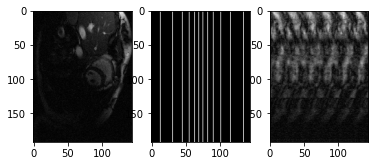

In [45]:
import numpy as np
from skimage.metrics import structural_similarity
from skimage.metrics import normalized_root_mse
from skimage.metrics import peak_signal_noise_ratio
import pickle
import matplotlib.pyplot as plt
from numpy.fft import*
import cfl
import compressed_sensing as cs
from gro import GRO

def kt2xt(kt, dim=(-2,-1)):
    "kt:[times,kx,ky,]"
    "dim is the dimention of nx, ny"
    xt = img = fftshift(ifftn(ifftshift(kt, axes=dim), axes=dim), axes=dim)
    return xt

raw_data_path = "/content/fs_0038_3T.pkl"

with open(raw_data_path, 'rb') as f:
    data_dict = pickle.load(f)
scale = 10000
kt = data_dict['kt'] * scale # (16, 20, 192, 144)  (nt, ncoil, nx, ny)

xt = kt2xt(kt)   # (16, 20, 192, 144)  (nt, ncoil, nx, ny)
coil_sens = data_dict['coil_sens']  # (20, 192, 144)  (ncoil, nx, ny)
nt,nC,nx,ny = np.shape(kt)

ACC = 12
print("ACC,",ACC)
mask_gro = GRO(ny//ACC, nt, ny)  #[144,16,1]
mask_gro = np.squeeze(mask_gro)
mask_gro = np.expand_dims(mask_gro,0).repeat(nx,0)
mask_gro = np.expand_dims(mask_gro, 0).repeat(nC, 0)
mask_gro = mask_gro.transpose(3,0,1,2)   # 16, 20, 192, 144
print('size of mask_gro', np.shape(mask_gro))
k_und = mask_gro * kt
x_und = kt2xt(k_und) 


plt.subplot(1,3,1)
plt.imshow(np.abs(xt[10,3]), cmap='gray')
plt.subplot(1,3,2)
plt.imshow(np.abs(mask_gro[10,0,:,:]), cmap='gray')
plt.subplot(1,3,3)
plt.imshow(np.abs(x_und[10,3,:,:]), cmap='gray')
plt.show()


In [46]:
cfl.writecfl(name="coil_sens", array=coil_sens)
cfl.writecfl(name="k_und", array=k_und)

adjust the dimention of input data, according to https://github.com/mrirecon/bart-webinars/blob/master/webinar2/dynamic_mri/bart_webinar_dynamic_mri.pdf

In [47]:
%%bash
# bart transpose -h

#[144, 192]
bart show -m k_und
bart transpose 0 10 k_und k_unt
bart transpose 3 0 k_unt k_unt
bart transpose 2 1 k_unt k_unt
bart transpose 2 3 k_unt k_unt
bart show -m k_unt
#[144, 192]
bart show -m coil_sens
bart transpose 0 3 coil_sens coil_sens_
bart transpose 2 0 coil_sens_ coil_sens_
bart show -m coil_sens_

Type: complex float
Dimensions: 16
AoD:	16	20	192	144	1	1	1	1	1	1	1	1	1	1	1	1
Type: complex float
Dimensions: 16
AoD:	144	192	1	20	1	1	1	1	1	1	16	1	1	1	1	1
Type: complex float
Dimensions: 16
AoD:	20	192	144	1	1	1	1	1	1	1	1	1	1	1	1	1
Type: complex float
Dimensions: 16
AoD:	144	192	1	20	1	1	1	1	1	1	1	1	1	1	1	1


In [ ]:
%%bash
REG=0.001
ITER=50
###-u0.01是data consistency的hyperparameter. 越小越好，但是过小会导致强烈额噪音
###-RL第二个冒号后面的是regulization的hyperparameter
# bart pics -h
bart pics -S -d5 -u0.1 -RW:3:0:0.00001 -RT:$(bart bitmask 10):0:$REG -i$ITER k_unt coil_sens_ output  #total variation contraint
# bart pics -u0.0001 -m -d5 -RL:$(bart bitmask 0 1 2):7:0.00001 -b6 -i50 k_unt coil_sens_ output   #PCA constraint
# bart pics -u0.0001 -m -d5 -RF:$(bart bitmask 10):0:0.00001 -b6 -i50 k_unt coil_sens_ output   #FFT constraint

# bart pics -u0.1 -m -d5 -l2 -i50 k_unt coil_sens_ output

recon_img shape (144, 192, 16)
after rotate (16, 192, 144)
mean_xgnd 0.10210509332808147
mean_cs 0.10182689
compress sensing, ACC=12
psnr:  25.956
ssim:  0.729
NRMSE 0.177



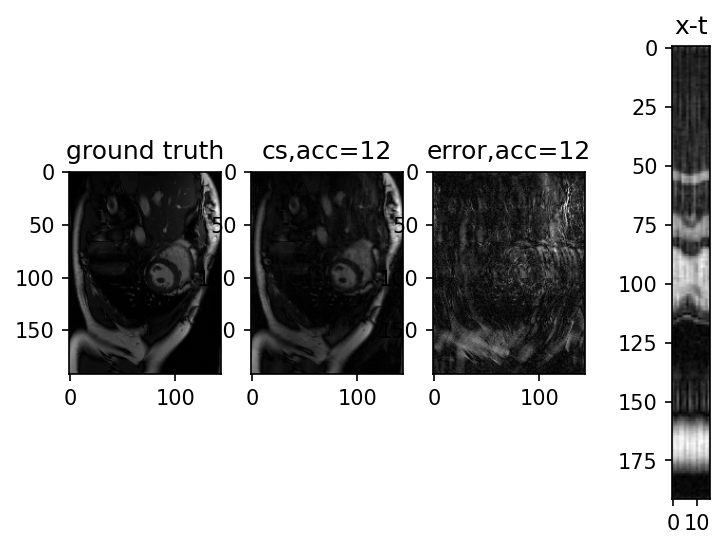

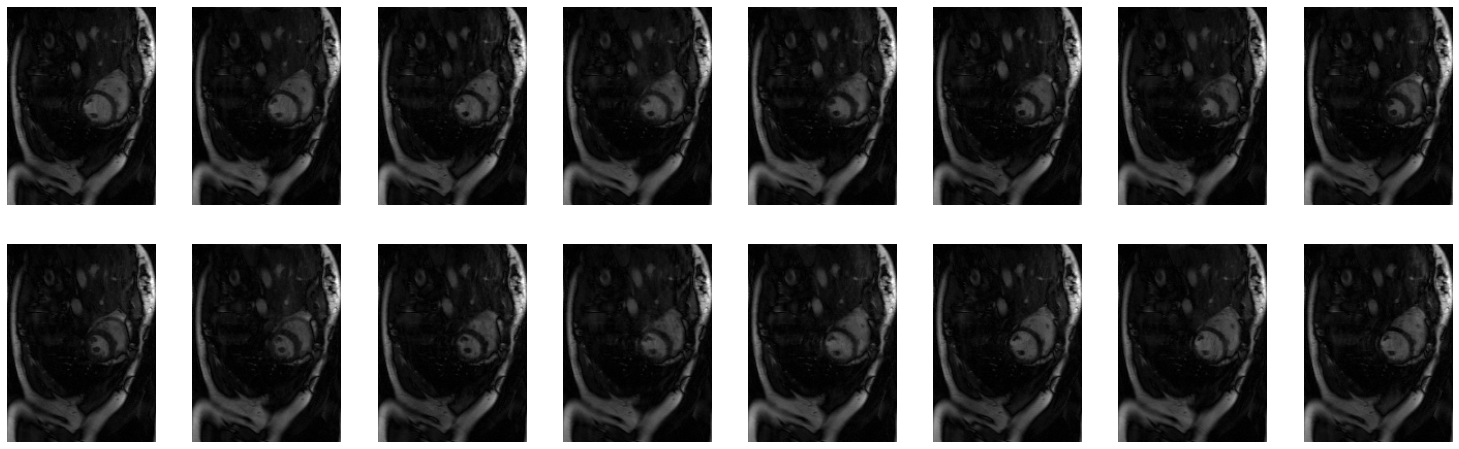

In [49]:
import numpy as np
import matplotlib.pyplot as plt

def map(image):
    max = np.max(np.abs(image))
    min = np.min(np.abs(image))
    return (image-min)/(max-min)

def seq_map(image):
  for i in range(image.shape[0]):
    image[i] = map(image[i])
  return image


recon_img = cfl.readcfl(name="output")
recon_img = recon_img.squeeze()
print("recon_img shape", np.shape(recon_img))
recon_img = recon_img.transpose(2,1,0) 
recon_img = seq_map(recon_img)
print("after rotate",np.shape(recon_img))
nT = np.shape(recon_img)[0]


def display(title, x_gnd, recon_img):
    print(title)
    psnr = peak_signal_noise_ratio(np.abs(x_gnd),np.abs(recon_img),data_range=np.abs(np.max(x_gnd)))
    print('psnr: ', "%.3f" % psnr)
    ssim = structural_similarity(np.abs(x_gnd),np.abs(recon_img),data_range=np.abs(np.max(x_gnd)))
    print('ssim: ', "%.3f" %ssim)
    NRMSE = normalized_root_mse(np.abs(x_gnd),np.abs(recon_img))
    print('NRMSE', "%.3f" %NRMSE)
    print()

def build_gnd_xt(data_path):
    with open(data_path, 'rb') as f:
        data_dict = pickle.load(f)
    nt = data_dict['kt'].shape[0]
    nC = data_dict['kt'].shape[1]

    data_dict['coil_sens'] = np.tile(data_dict['coil_sens'][np.newaxis], (nt, 1, 1, 1))  # [nt, coil, nx, ny]
    scale = 10000
    kt = data_dict['kt'] * scale  # [nt, coil, nx, ny]
    xt = kt2xt(kt)

    coil_sens = data_dict['coil_sens']
    x_gnd = np.sum(coil_sens.conjugate() * xt, axis=1) / (np.linalg.norm(coil_sens, axis=1) + 1e-8)  # [nt,nx,ny]
    return x_gnd


data_path = raw_data_path
x_gnd = build_gnd_xt(data_path)
x_gnd = seq_map(x_gnd)

mean_xgnd = np.mean(np.abs(x_gnd))
mean_cs = np.mean(np.abs(recon_img))
print("mean_xgnd", mean_xgnd)
print("mean_cs", mean_cs)

title = "compress sensing, ACC={}".format(ACC)
display(title=title, x_gnd=x_gnd, recon_img=recon_img)

plt.figure(dpi=150)
plt.subplot(141)
plt.title("ground truth")
plt.imshow(np.abs(x_gnd[10]), cmap='gray')
plt.subplot(142)
plt.title("cs,acc={}".format(ACC))
plt.imshow(np.abs(recon_img[10]), cmap='gray')
plt.subplot(143)
plt.title("error,acc={}".format(ACC))
plt.imshow(np.abs((x_gnd-recon_img)[10]), cmap='gray')
plt.subplot(144)
plt.title("x-t")
plt.imshow(np.abs(recon_img[:,:,90].transpose(1,0)), cmap='gray')
plt.show()



f, ax = plt.subplots(2, 8, figsize=(26, 8))
for t in range(nT):
    # plt.subplot(2, 8, t + 1)
    axx = t//8
    axy = t%8
    ax[axx, axy].imshow(np.abs(recon_img[t]), cmap='gray')
    ax[axx, axy].set_axis_off()
    ax[axx, axy].set_xticklabels([])
    ax[axx, axy].set_yticklabels([])
    plt.axis('off')


In [51]:
file_name = "cs_tv,ACC{}.pkl".format(ACC)
f = open(file_name, 'wb')
pickle.dump(recon_img, f)
f.close()